In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

from imblearn.over_sampling import SMOTE

import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [3]:
df = pd.read_csv("diabetes.csv")

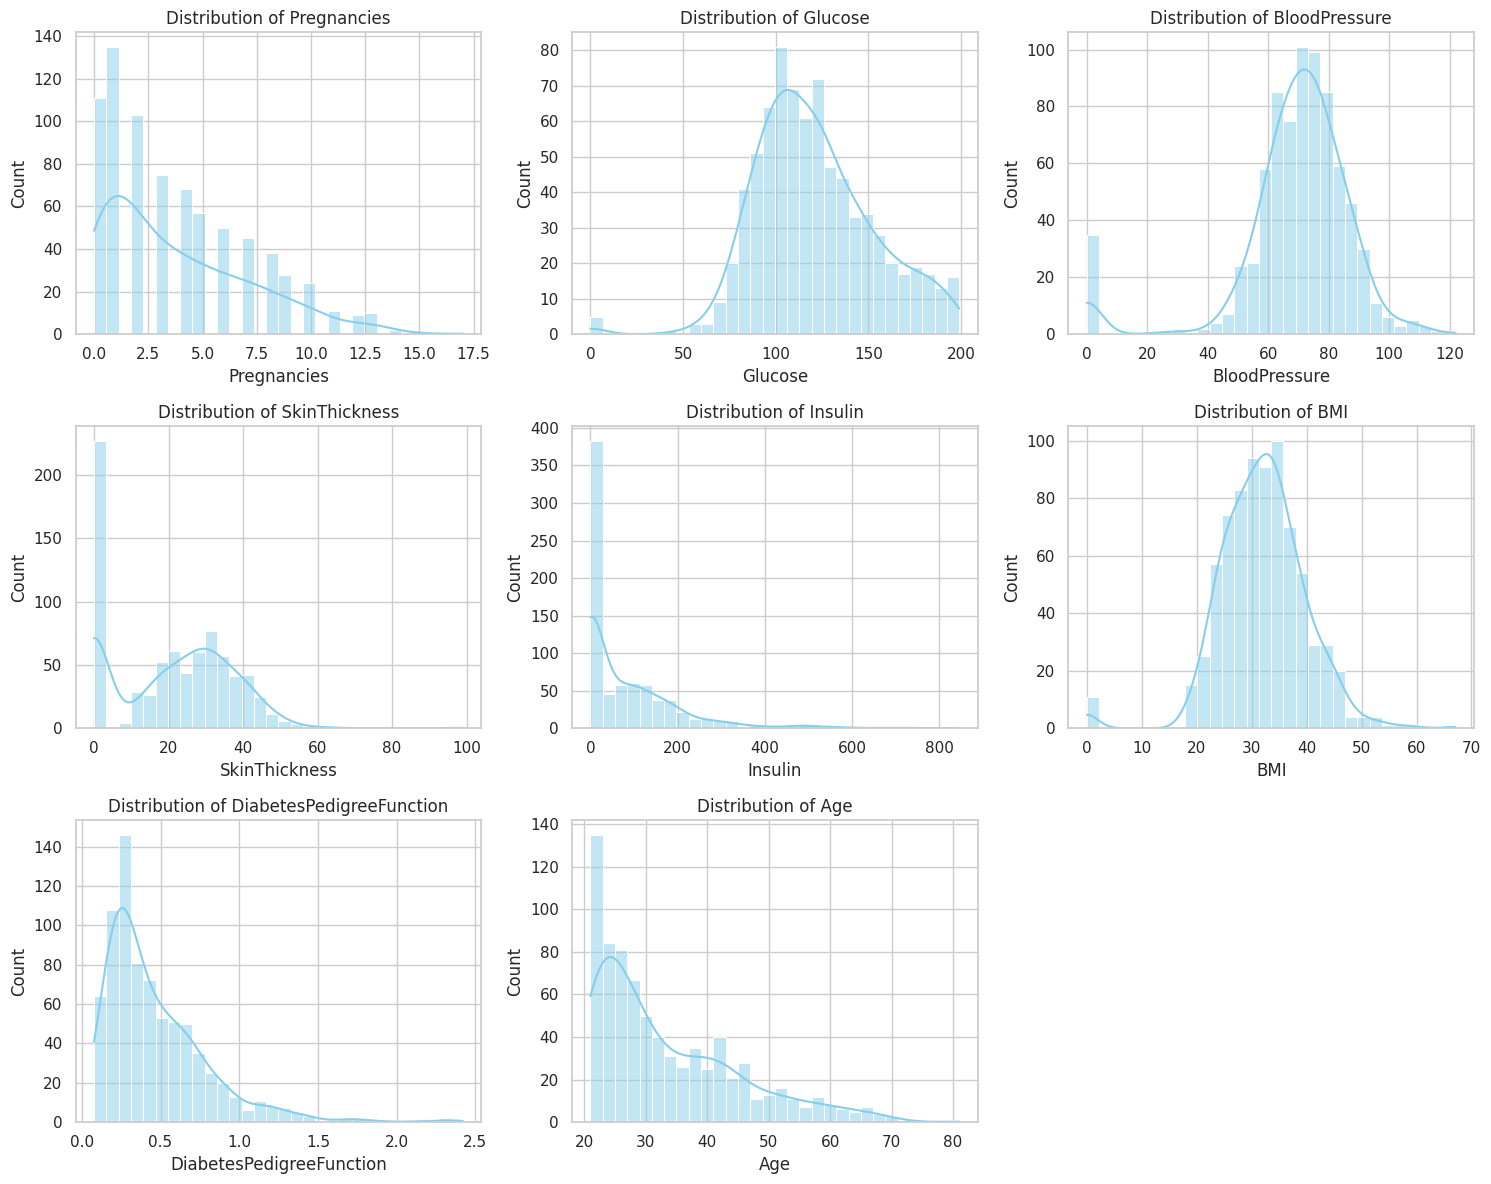

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

/tmp/ipython-input-876735437.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette='Set2')
/tmp/ipython-input-876735437.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette='Set2')
/tmp/ipython-input-876735437.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette='Set2')
/tmp/ipython-input-876735437.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effec

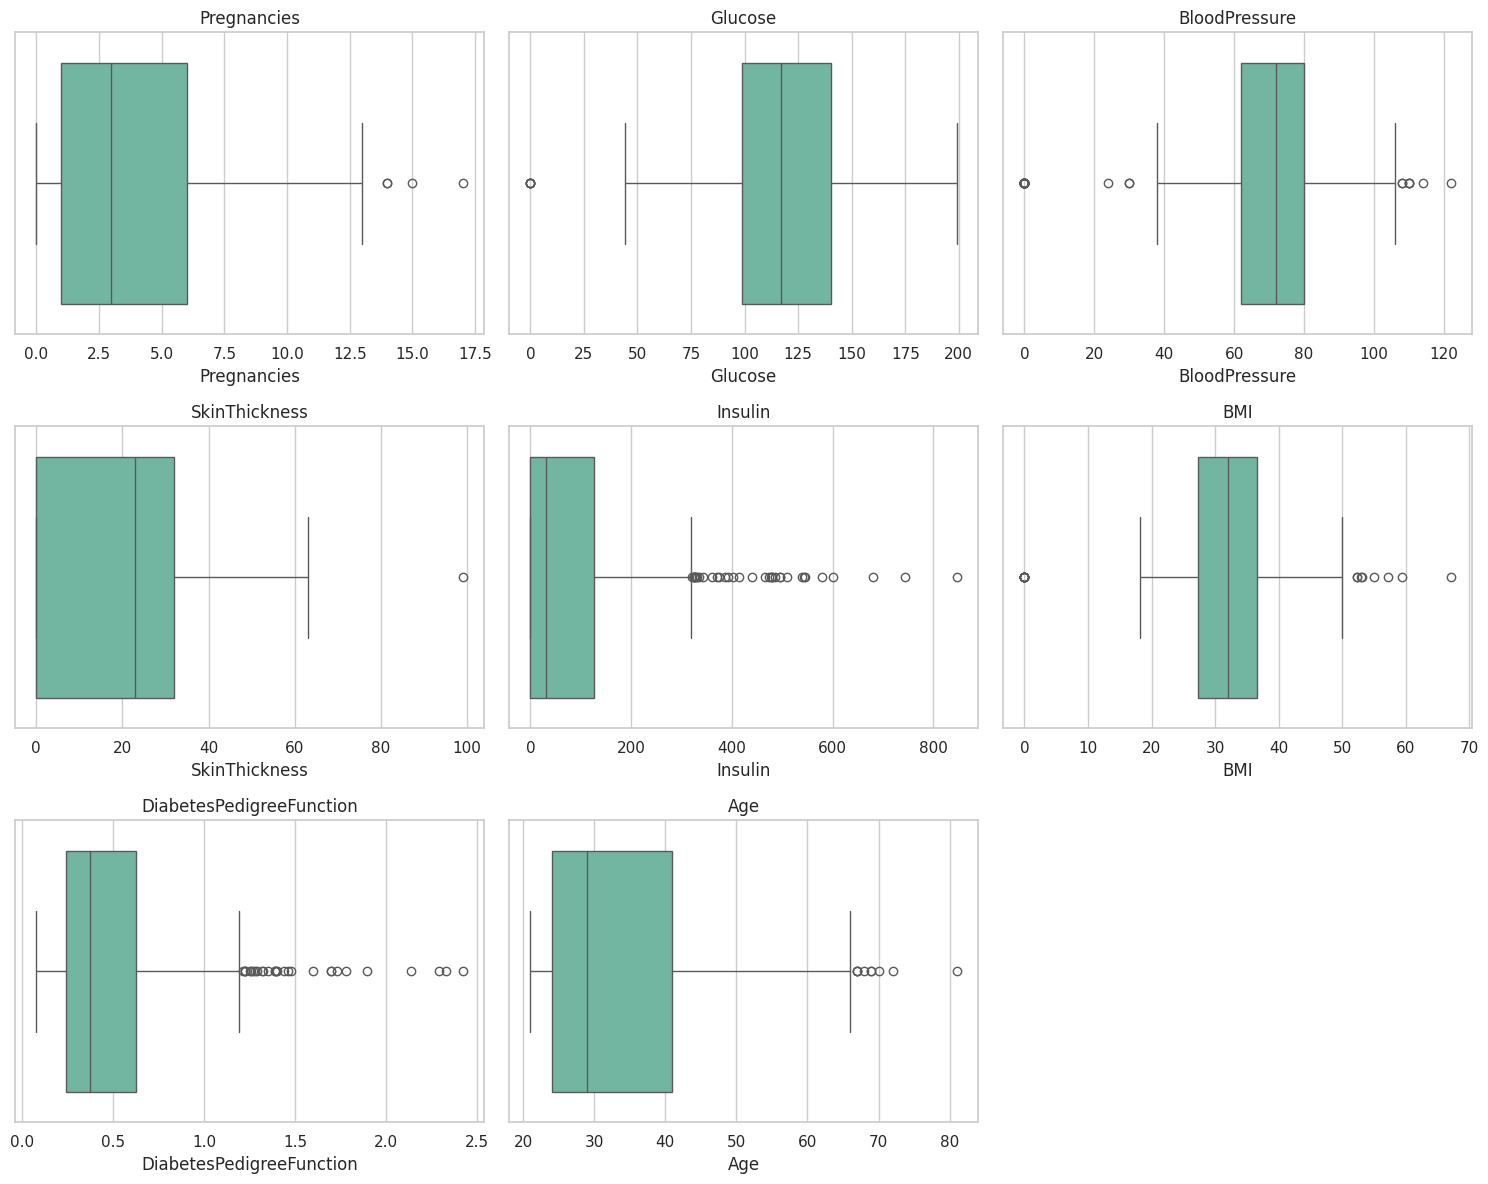

In [5]:
# Boxplot لكل عمود
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[column], palette='Set2')
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1388206492.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=column, data=df, palette='Set2')
/tmp/ipython-input-1388206492.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=column, data=df, palette='Set2')
/tmp/ipython-input-1388206492.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=column, data=df, palette='Set2')
/tmp/ipython-input-1388206492.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

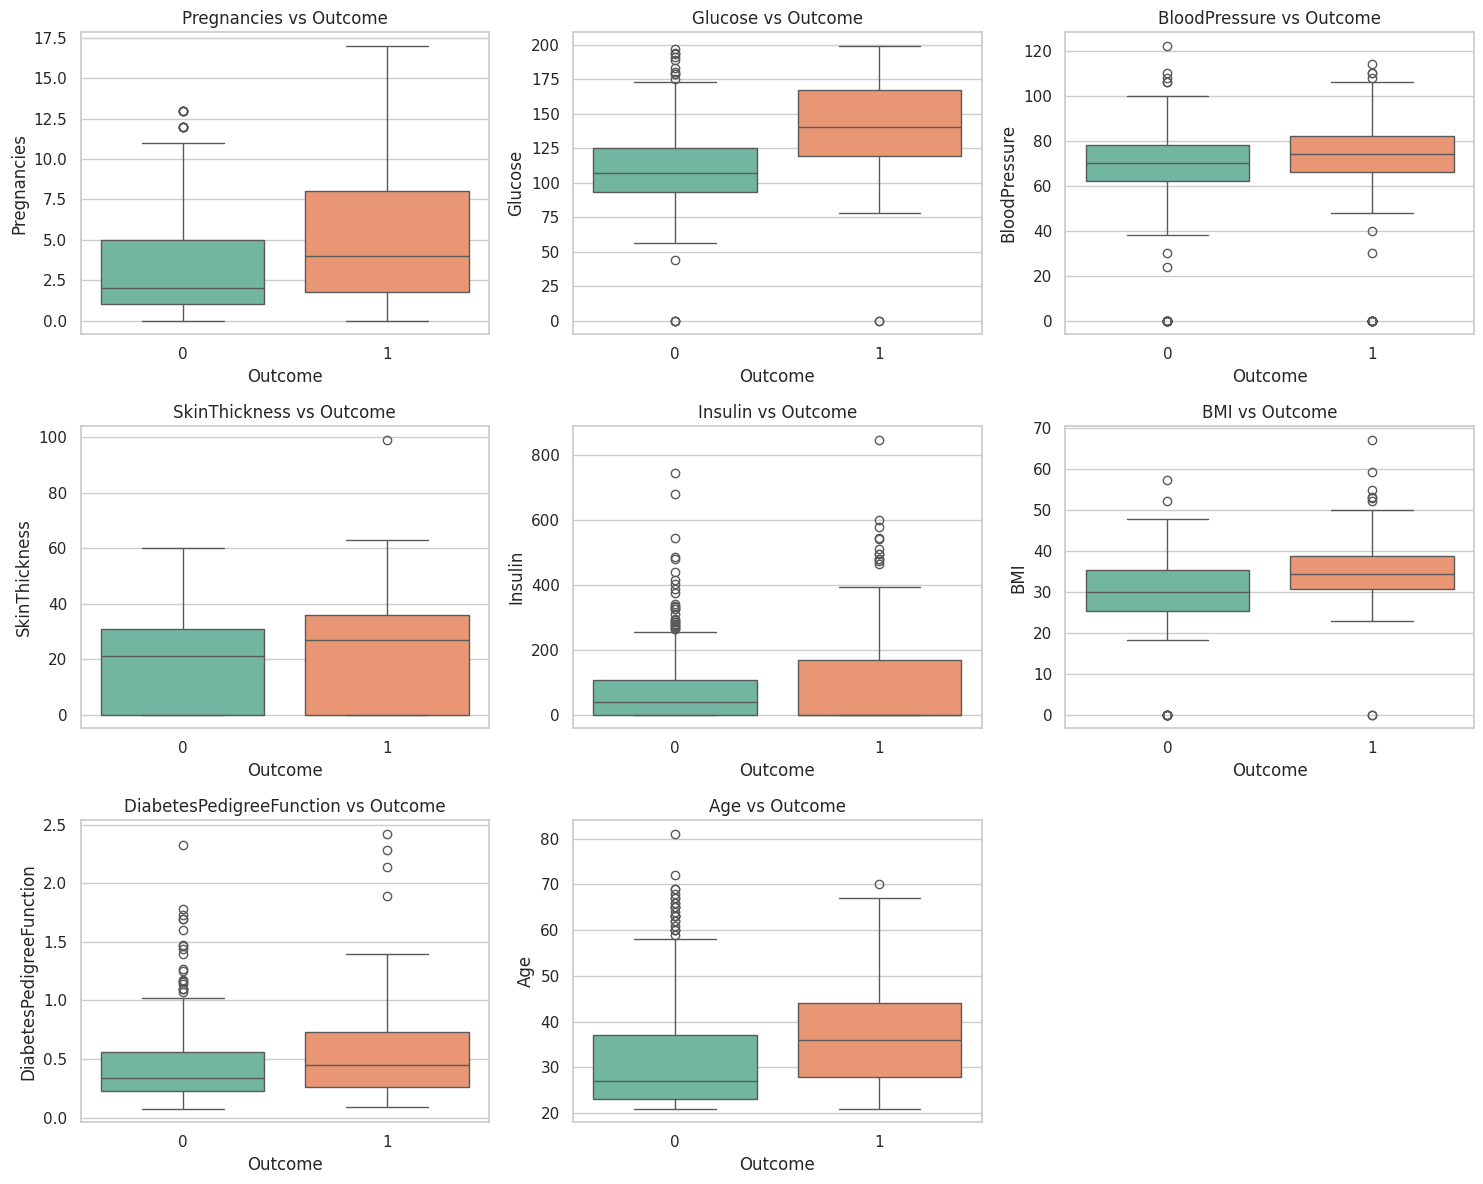

In [6]:
# Boxplot مقابل Outcome
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=column, data=df, palette='Set2')
    plt.title(f'{column} vs Outcome')
plt.tight_layout()
plt.show()

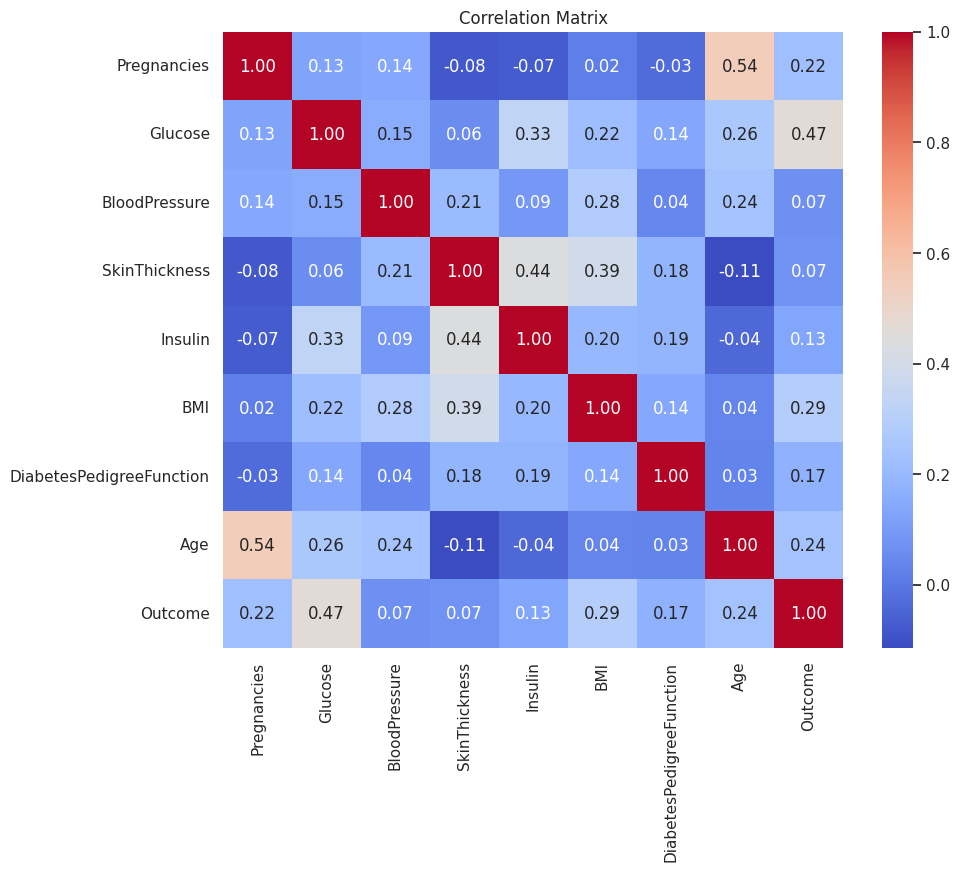

In [7]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# توزيع Outcome
counts = df['Outcome'].value_counts()
percentages = df['Outcome'].value_counts(normalize=True) * 100
outcome_df = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)})
outcome_df.index = ['No Diabetes (0)', 'Diabetes (1)']
print(outcome_df)

                 Count  Percentage
No Diabetes (0)    500        65.1
Diabetes (1)       268        34.9


/tmp/ipython-input-2481198204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_df.index, y=outcome_df['Count'], palette='Set2')


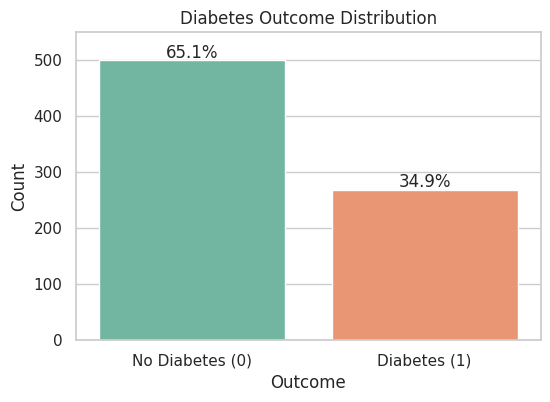

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(x=outcome_df.index, y=outcome_df['Count'], palette='Set2')
for i, (count, pct) in enumerate(zip(outcome_df['Count'], outcome_df['Percentage'])):
    plt.text(i, count + 5, f'{pct}%', ha='center', fontsize=12)
plt.title('Diabetes Outcome Distribution')
plt.ylabel('Count')
plt.xlabel('Outcome')
plt.ylim(0, outcome_df['Count'].max() + 50)
plt.show()

In [11]:
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(df.drop('Outcome', axis=1))
X_transformed_df = pd.DataFrame(X_transformed, columns=df.columns[:-1])
X_transformed_df['Outcome'] = df['Outcome']

In [12]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_cleaned = remove_outliers_iqr(X_transformed_df, 'Insulin')
df_cleaned = remove_outliers_iqr(df_cleaned, 'DiabetesPedigreeFunction')

In [13]:
glucose = ctrl.Antecedent(np.arange(0, 202, 1), 'glucose')
bmi = ctrl.Antecedent(np.arange(0, 71, 1), 'bmi')
risk = ctrl.Consequent(np.arange(0, 11, 1), 'risk')

glucose['low'] = fuzz.trimf(glucose.universe, [0, 0, 100])
glucose['medium'] = fuzz.trimf(glucose.universe, [90, 125, 150])
glucose['high'] = fuzz.trimf(glucose.universe, [140, 200, 200])

bmi['low'] = fuzz.trimf(bmi.universe, [0, 0, 18])
bmi['medium'] = fuzz.trimf(bmi.universe, [17, 25, 35])
bmi['high'] = fuzz.trimf(bmi.universe, [30, 50, 70])

risk['low'] = fuzz.trimf(risk.universe, [0, 0, 4])
risk['medium'] = fuzz.trimf(risk.universe, [3, 5, 7])
risk['high'] = fuzz.trimf(risk.universe, [6, 10, 10])

rules = [
    ctrl.Rule(glucose['low'] & bmi['low'], risk['low']),
    ctrl.Rule(glucose['medium'] & bmi['medium'], risk['medium']),
    ctrl.Rule(glucose['high'] | bmi['high'], risk['high']),
]

risk_ctrl = ctrl.ControlSystem(rules)
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

fuzzy_risks = []
for i in range(len(df)):
    try:
        if df.iloc[i]['BMI'] == 0 or df.iloc[i]['Glucose'] == 0:
            fuzzy_risks.append(np.nan)
            continue
        risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)
        risk_sim.input['glucose'] = df.iloc[i]['Glucose']
        risk_sim.input['bmi'] = df.iloc[i]['BMI']
        risk_sim.compute()
        fuzzy_risks.append(risk_sim.output['risk'])
    except Exception as e:
        print(f"🚨 Error at index {i}: {e}")
        fuzzy_risks.append(np.nan)

df['fuzzy_risk_score'] = fuzzy_risks
df['fuzzy_risk_score'] = df['fuzzy_risk_score'].fillna(df['fuzzy_risk_score'].mean())

🚨 Error at index 1: 'risk'
🚨 Error at index 3: 'risk'
🚨 Error at index 32: 'risk'
🚨 Error at index 47: 'risk'
🚨 Error at index 52: 'risk'
🚨 Error at index 55: 'risk'
🚨 Error at index 62: 'risk'
🚨 Error at index 82: 'risk'
🚨 Error at index 90: 'risk'
🚨 Error at index 97: 'risk'
🚨 Error at index 103: 'risk'
🚨 Error at index 149: 'risk'
🚨 Error at index 158: 'risk'
🚨 Error at index 172: 'risk'
🚨 Error at index 174: 'risk'
🚨 Error at index 180: 'risk'
🚨 Error at index 183: 'risk'
🚨 Error at index 194: 'risk'
🚨 Error at index 210: 'risk'
🚨 Error at index 218: 'risk'
🚨 Error at index 232: 'risk'
🚨 Error at index 234: 'risk'
🚨 Error at index 252: 'risk'
🚨 Error at index 310: 'risk'
🚨 Error at index 353: 'risk'
🚨 Error at index 368: 'risk'
🚨 Error at index 383: 'risk'
🚨 Error at index 398: 'risk'
🚨 Error at index 418: 'risk'
🚨 Error at index 432: 'risk'
🚨 Error at index 434: 'risk'
🚨 Error at index 450: 'risk'
🚨 Error at index 461: 'risk'
🚨 Error at index 463: 'risk'
🚨 Error at index 466: 'ris

In [14]:
X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [15]:
models = {
    'HistGradientBoosting': HistGradientBoostingClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'SGDClassifier': SGDClassifier(loss='log_loss', max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000)
}

Training model: HistGradientBoosting
✅ HistGradientBoosting Accuracy: 0.7208
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.59      0.69      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154

Training model: BaggingClassifier
✅ BaggingClassifier Accuracy: 0.6818
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       100
           1       0.54      0.59      0.57        54

    accuracy                           0.68       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.69      0.68      0.68       154

Training model: SGDClassifier
✅ SGDClassifier Accuracy: 0.7013
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       100
           1       0.56   

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


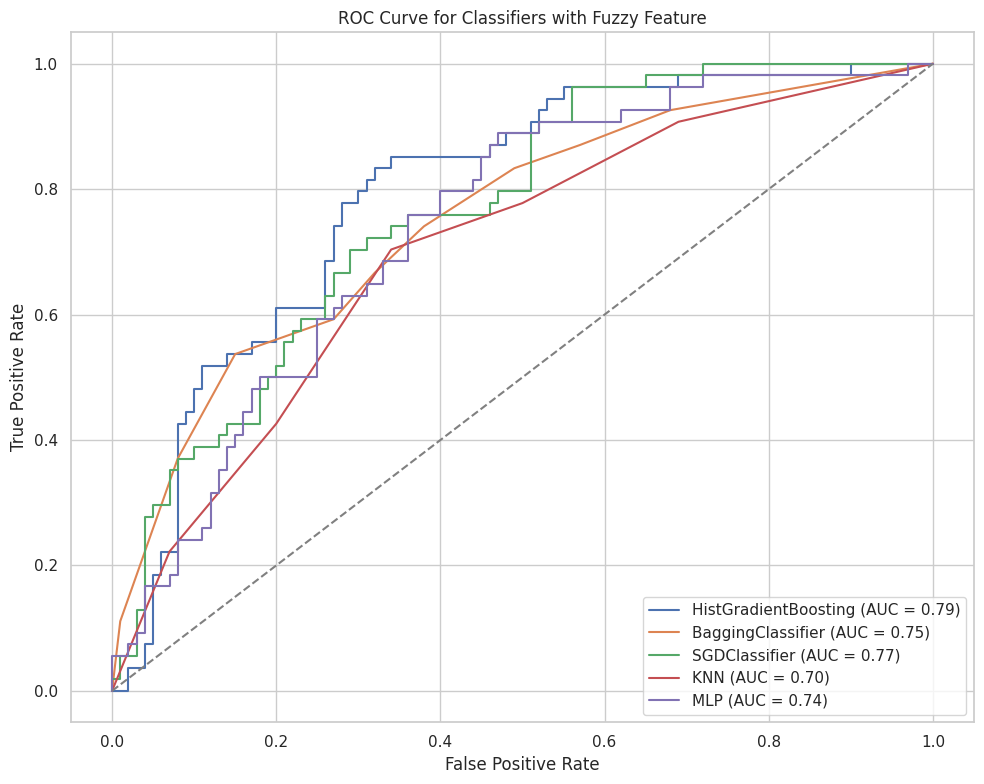

In [21]:
from imblearn.pipeline import Pipeline
results = []
plt.figure(figsize=(10, 8))

for name, model in models.items():
    print(f"Training model: {name}")

    pipeline = Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),   # يعمل هنا
        ('clf', model)
    ])

    pipeline.fit(X_train, y_train)
    joblib.dump(pipeline, f'{name}_fuzzy_model.pkl')

    if hasattr(model, 'predict_proba'):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_proba = pipeline.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    acc = accuracy_score(y_test, pipeline.predict(X_test))
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, pipeline.predict(X_test)))
    print("="*50)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'AUC': roc_auc
    })

# رسم ROC النهائي
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers with Fuzzy Feature')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\n📋 جدول مقارنة النماذج (Accuracy و AUC):")
print(results_df)


📋 جدول مقارنة النماذج (Accuracy و AUC):
                  Model  Accuracy       AUC
0  HistGradientBoosting  0.720779  0.793333
1         SGDClassifier  0.701299  0.765370
2                   MLP  0.694805  0.740926
3     BaggingClassifier  0.681818  0.752315
4                   KNN  0.675325  0.703241
